In [1]:
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. Data Cleaning 

Remove features that have more than 10 missing values.

Forward fill missing values

In [2]:
df_macro = pd.read_csv('macro_raw.csv')[:-1] #remove last row
for col in df_macro.columns:
  if df_macro[col].isna().sum() > 10:
    df_macro.drop(col, axis=1, inplace=True)

df_macro.fillna(method='ffill', inplace=True)  # forward fill last month and missing values in between
df_macro.rename(columns={'sasdate': 'Date'}, inplace=True)
df_macro.head(9)

,Date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,IPNCONGD,IPBUSEQ,IPMAT,IPDMAT,IPNMAT,IPMANSICS,IPB51222S,IPFUELS,CUMFNS,HWI,HWIURATIO,CLF16OV,CE16OV,UNRATE,UEMPMEAN,UEMPLT5,UEMP5TO14,UEMP15OV,UEMP15T26,UEMP27OV,CLAIMSx,PAYEMS,USGOOD,CES1021000001,USCONS,MANEMP,DMANEMP,NDMANEMP,SRVPRD,...,BAA,COMPAPFFx,TB3SMFFM,TB6SMFFM,T1YFFM,T5YFFM,T10YFFM,AAAFFM,BAAFFM,EXSZUSx,EXJPUSx,EXUSUKx,EXCAUSx,WPSFD49207,WPSFD49502,WPSID61,WPSID62,OILPRICEx,PPICMM,CPIAUCSL,CPIAPPSL,CPITRNSL,CPIMEDSL,CUSR0000SAC,CUSR0000SAD,CUSR0000SAS,CPIULFSL,CUSR0000SA0L2,CUSR0000SA0L5,PCEPI,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,MZMSL,DTCOLNVHFNM,DTCTHFNM,INVEST
0,Transform:,5.000,5.0,5.000,5.0000,5.00000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,2.0000,2.0,2.000000,5.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,...,2.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,5.0000,5.0000,5.0000,5.0000,6.0,6.0,6.0,6.0,6.00,6.0,6.00,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.000,6.000,6.000,6.000,6.00,6.00,6.00,6.0,6.0,6.0,6.0000
1,1/1/1959,2437.296,2288.8,17.302,292258.8329,18235.77392,22.6250,23.4581,22.1904,32.4078,21.9882,37.7280,7.9955,21.2146,12.6047,30.5372,21.1492,20.2590,38.3482,80.1973,1357.0,0.333579,67936.0,63868.0,6.0,16.3,1574.0,1169.0,1396.0,594.0,802.0,291078.0,52478.0,18796.0,713.0,2993.0,14998.0,8740.0,6258.0,33682.0,...,4.87,0.82,0.34,0.61,0.88,1.53,1.54,1.64,2.39,4.3122,359.8417,2.8065,0.9671,33.1,33.4,30.6,31.6,3.00,32.5,29.01,44.8,29.3,21.1,33.3,38.1,22.9,28.9,30.7,29.6,16.074,56.918,17.791,11.358,2.13,2.45,2.04,274.9,6476.0,12298.0,84.2043
2,2/1/1959,2446.902,2297.0,17.482,294429.5453,18369.56308,23.0681,23.7747,22.3827,32.6455,22.1036,38.0886,8.1025,21.8864,13.1853,31.0719,21.5379,20.2038,37.8258,81.4428,1421.0,0.358386,67649.0,63684.0,5.9,15.5,1554.0,1164.0,1277.0,545.0,732.0,282958.0,52688.0,18890.0,704.2,2980.0,15115.0,8839.0,6276.0,33798.0,...,4.89,0.83,0.27,0.70,1.11,1.53,1.53,1.71,2.46,4.3133,359.8417,2.8093,0.9748,33.2,33.4,30.7,31.4,3.00,32.5,29.00,44.7,29.4,21.2,33.3,38.1,23.0,28.9,30.7,29.6,16.089,56.951,17.798,11.375,2.14,2.46,2.05,276.0,6476.0,12298.0,83.5280
3,3/1/1959,2462.689,2314.0,17.647,293425.3813,18523.05762,23.4004,23.9186,22.4925,32.6455,22.5365,37.9083,8.1900,22.4549,13.7048,31.5387,21.8749,20.3417,38.7835,82.4769,1524.0,0.400947,68068.0,64267.0,5.6,15.3,1459.0,1093.0,1210.0,530.0,680.0,260346.0,53014.0,19069.0,704.1,3013.0,15259.0,8965.0,6294.0,33945.0,...,4.85,0.55,0.00,0.33,0.81,1.19,1.19,1.33,2.05,4.3228,359.8417,2.8127,0.9698,33.2,33.3,30.7,31.5,2.97,32.9,28.97,44.7,29.6,21.3,33.2,38.3,23.0,28.9,30.7,29.6,16.100,57.022,17.785,11.395,2.15,2.45,2.07,277.4,6508.0,12349.0,81.6405
4,4/1/1959,2478.744,2330.3,17.584,299331.6505,18534.46600,23.8989,24.2641,22.8221,33.1606,22.6807,38.5393,8.4040,23.0751,14.1173,32.5154,22.3414,20.4243,38.6093,83.9922,1589.0,0.444973,68339.0,64768.0,5.2,14.9,1494.0,934.0,1039.0,408.0,631.0,246413.0,53321.0,19269.0,705.2,3085.0,15385.0,9077.0,6308.0,34052.0,...,4.86,0.46,-0.01,0.31,0.76,1.16,1.16,1.27,1.90,4.3226,359.8417,2.8165,0.9636,33.2,33.4,30.7,31.7,2.97,32.7,28.98,44.8,29.7,21.3,33.2,38.3,23.1,29.0,30.7,29.6,16.132,57.080,17.796,11.436,2.16,2.47,2.08,278.1,6620.0,12484.0,81.8099
5,5/1/1959,2493.228,2345.8,17.796,301372.9597,18679.66354,24.2589,24.4655,23.0418,33.3190,23.1424,38.5393,8.6764,23.6694,14.6062,32.8075,22.6524,20.7275,37.8694,84.9159,1655.0,0.475711,68178.0,64699.0,5.1,14.7,1479.0,1005.0,965.0,390.0,575.0,246952.0,53550.0,19378.0,710.0,3087.0,15487.0,9160.0,6327.0,34172.0,...,4.96,0.66,-0.06,0.43,1.06,1.45,1.41,1.47,2.06,4.3228,359.8417,2.8145,0.9630,33.3,33.3,30.9,31.5,2.97,32.9,29.04,44.9,29.7,21.4,33.3,38.4,23.2,29.1,30.7,29.6,16.140,57.175,17.777,11.454,2.17,2.48,2.08,280.1,6753.0,12646.0,80.7315
6,6/1/1959,2500.989,2352.9,17.861,301364.8427,18849.75209,24.2866,24.6382,23.2066,33.1606,23.3156,38.2689,8.8806,23.5143,14.4993,3

# 2. Data Processing 
Convert the features into stationary form by applying the necessary transformations.

Add 1,3,6,9,12 months lags of the features

In [3]:
# Keep transformation codes for each variable in a dictionary 
transformation_codes = {}
df_tmp=pd.DataFrame(columns = df_macro.columns)
for col in df_macro.columns:
  df_tmp[col]= df_macro[col].iloc[1:] 
  transformation_codes[col] = df_macro[col].iloc[0]
df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])

In [4]:

first10pairs = {k: transformation_codes[k] for k in list(transformation_codes)[:10]}
first10pairs

{'CMRMTSPLx': 5.0,
 'DPCERA3M086SBEA': 5.0,
 'Date': 'Transform:',
 'INDPRO': 5.0,
 'IPCONGD': 5.0,
 'IPFINAL': 5.0,
 'IPFPNSS': 5.0,
 'RETAILx': 5.0,
 'RPI': 5.0,
 'W875RX1': 5.0}

In [5]:
def transform(df_col, code):
        """
        Transforms each column of dataframe (df_col) according to code
        Transformations for each code are shown in appendix

        Parameters
        ----------
        df_col: pandas dataframe column

        code: int or float
        """
        if code == 1:
            df_col.apply(lambda x: x)
            return df_col
        elif code == 2:
            df_col = df_col.diff()
            return df_col
        elif code == 3:
            df_col = df_col.diff(periods=2)
            return df_col
        elif code == 4:
            df_col = df_col.apply(np.log)
            return df_col
        elif code == 5:
            df_col = df_col.apply(np.log)
            df_col = df_col.diff(periods=2)
            return df_col
        elif code == 6:
            df_col = df_col.apply(np.log)
            df_col = df_col.diff(periods=2)
            return df_col
        elif code == 7:
            df_col = df_col.pct_change()
            df_col = df_col.diff()
            return df_col


In [6]:
data_transformed=pd.DataFrame(columns=df_tmp.columns)
for col in df_tmp.columns:
  if col == 'Date':
    data_transformed[col] = df_tmp[col]
  else:
    data_transformed[col] = transform(df_tmp[col], transformation_codes[col])

In [7]:
def add_lag(lag_values):
  for col in data_transformed.drop(['Date'], axis=1):
    for n in lag_values:
      data_transformed['{} {}M lag'.format(col, n)] = data_transformed[col].shift(n).ffill().values

lag_values = [1,3,6,9,12]
add_lag(lag_values)
data_transformed.dropna(axis=0, inplace=True)
data_transformed.head
print('MacroFeatures shape:', data_transformed.shape)
print('Start date: '+ str(data_transformed.Date.iloc[0])+' End date: '+str(data_transformed.Date.iloc[-1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  after removing the cwd from sys.path.


<bound method NDFrame.head of           Date       RPI  ...  INVEST 9M lag  INVEST 12M lag
15  1960-03-01  0.003055  ...      -0.038791       -0.030921
16  1960-04-01  0.005336  ...      -0.021701       -0.020784
17  1960-05-01  0.005829  ...      -0.017855       -0.011197
18  1960-06-01  0.003192  ...      -0.027018       -0.038791
19  1960-07-01  0.002621  ...      -0.014082       -0.021701
..         ...       ...  ...            ...             ...
737 2020-05-01  0.076600  ...       0.015036        0.016372
738 2020-06-01 -0.061109  ...       0.026829        0.011896
739 2020-07-01 -0.010193  ...       0.020227        0.012218
740 2020-08-01 -0.021447  ...       0.014206        0.015036
741 2020-09-01 -0.021078  ...       0.010310        0.026829

[727 rows x 709 columns]>

MacroFeatures shape: (727, 709)
Start date: 1960-03-01 00:00:00 End date: 2020-09-01 00:00:00


In [8]:
data_transformed.to_csv('macro_processed.csv',index=False)

# Model Framework

# Machine Learning Models

Here, we look at regime modeling problem from an algorithmic approach and seek a function  𝑓  that approximates the relationship between feature matrix  𝑋  and regime labels  𝑦 . In order to understand dynamics, we explore both linear and nonlinear classifiers with ensembles for regime prediction. For further details refer to Hastie et al. (2013).

(i) Linear Models Logit and probit models are the most common linear models for classification problems. The main difference is the choice of a cumulative distribution function. Probit assumes standard normal variable, whereas logistic uses standard logistically distributed random variable for distribution specification. Early works on business cycle forecasting employ these models. We consider logistic regression along with  ℓ1  and  ℓ2  regularization terms to test linear dynamics.

(ii) Nonlinear Models Decision trees present one of the most successful non-parametric methods in ML applications in regression and classification problems. 

CART (Classification and Regression Trees) builds decision trees by recursively partitioning the feature space and assigns a label or class probabilities to each space for classification problems. 

CART takes a top-down approach by solving an optimization problem to find the best split at each node. 

Decision trees can capture nonlinear relationships in data and are interpretable over other ML methods. 

However, there are disadvantages: Their greedy nature leads to less accurate classifiers and a single decision tree is sensitive to training data.

# Evaluation Metrics

The model outputs are received in two forms: probability forecasts and binary classification of regime states. We consider multiple error metrics to evaluate a classification model performance. A natural metric is classification accuracy (ACC). For given probability prediction for positive state  𝑦̂ 𝑡  and binary label of the original state  𝑦𝑡

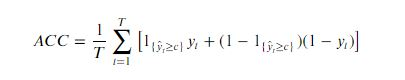


where  𝑐  is the threshold to get regime states which is set to natural choice of 50\%. 

State probability forecasts are important inputs for the portfolio models and quadratic probability score (QPS) evaluates prediction performance in terms of probabilities. Notice that QPS does not evaluate classification ability. If two models have different probability outputs, they might have same ACC score but not same QPS which is mean squared error of probability forecasts.

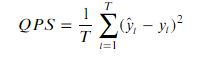

In a perfect prediction setting, QPS equals 0. The lower the value of QPS, the better the model performance.

Because of the imbalanced nature of the dataset we consider other evaluation metrics to avoid inflated error metrics. 

Receiver operating characteristic (ROC) curve is a common choice in imbalanced classification problems. 

ROC curve plots true positive rate (recall) ( 𝑡𝑝𝑟=𝑡𝑝/𝑡𝑝+𝑓𝑛 ) against false positive rate ( 𝑓𝑝𝑟=𝑓𝑝/𝑓𝑝+𝑡𝑛 ) at various threshold settings. 

Area under the ROC curve (AUC) generates summary statistic for ROC metric. 

In perfect prediction setting, ROC curve will be in inverted L-shape form with AUC metric 1. So the higher the AUC value, the better the model performance.

The Matthew's Correlation Coefficient (MCC) is also reported as an evaluation metric and deployed widely in the field of computational biology. MCC is calculated from the following:

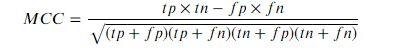

In perfect prediction setting MCC equals 1 and the worst value is -1. Therefore the higher the MCC score the better the classification performance.

Prediction Set-up

The analysis covers the sample period from 1959 until August 2020. 

The historical performance period is split into two segments: 1) 1959 to 1973 is used for hyper parameter tuning, and 2) the period from 1973 until August 2020 for out-of-sample testing.

ML models have two types of parameters: model parameters and hyper parameters. 

Model parameters can be learned from data but the hyper parameters need to be set in advance depending upon the model architecture. 

Important hyper parameters for the classifiers are regularization coefficient for logistic regression, depth of the trees, number of trees that are generated in ensembles, the maximum number of features considered in tree construction. 

Cross-validation is a common framework for hyper parameter tuning in the ML field. In the standard k-fold framework, training data is randomly grouped into k folds. 

In each iteration, model is trained on k-1 folds, and the remaining fold is used for validation. After k iteration, average of the model score is computed from validation sets.

 Since our dataset has a time series property, we implement the cross-validation to keep temporal dependency and avoid look ahead bias. We create  𝑘 -folds as block of time periods, and move training and validation sets in a rolling basis. 
 
After the model hyper parameter optimization, out-of-sample predictions are performed in a rolling window basis with a length of 150 months.

# 3. Data and Set-up

In [9]:
# if xgboost is not installed you can run this command in the cell
#!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import itertools
import seaborn as sns

# Classification Functions and metrics form scikit-learn library
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [10]:
df_macro = pd.read_csv('macro_processed.csv', parse_dates=['Date'])
# Load Stock Return dataset 
file_name = 'recession_dates.xlsx'
sheet_name = 'Regime_index3'
df = pd.read_excel(file_name, sheet_name)
df.to_csv('recession_dates.csv',index=False)
df_regime = pd.read_csv('recession_dates.csv',parse_dates = ['Date']) # Regime column shows recession and expansion periods. (Recession label:1)
df = df_macro.merge(df_regime, on='Date',how='left')
#split_date = '2007-08-01' # train and test set split date
#df_train, df_test = df[df['Date'] < split_date], df[df['Date'] >= split_date]
target_col = 'Regime_index3'
feature_col = df.columns.drop(['Regime_index3', 'Date'])

In [11]:
def error_metrics(df, roc=False):
  """
  Four classification error metrics that will be used to evaluate model performance
  ACC: accuracy (0-1) loss
  QPS: quadratic probability score
  MCC: MAtthew's Correlation Coefficient
  AUC: Area under the ROC curve
  """
  mcc = matthews_corrcoef(y_true=df.Regime, y_pred=df.crash_binary)
  mis_rate = df[df.Regime != df.crash_binary].shape[0] / df.shape[0]
  qps = sum((df.crash_prob - df.Regime) ** 2) / len(df)
  err_dict = {'ACC': 1 - mis_rate,
                'MCC': mcc,
                'QPS': qps}
  if roc == True:
    roc = roc_auc_score(y_true=df.Regime, y_score=df.crash_prob)
    err_dict['AUC'] = roc
  return err_dict

In [12]:
def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [13]:
def get_regime_dates(df):
        regime_dates = []
        crash_regime = 1
        normal_regime = 0

        regime = normal_regime  # initial regime
        for i, j, k in zip(df['Regime'],df['Date'], range(len(df))):
            if i == crash_regime and regime == normal_regime:  # regime switch from normal to crash
                regime_span = []
                regime = crash_regime
                regime_span.append(j)  # start of the crash regime date
            if i == normal_regime and regime == crash_regime:  # end of crash regime
                regime = normal_regime
                regime_span.append(df['Date'].iloc[k - 1])  # take end date from previous iteration
                regime_dates.append(regime_span)  # crash regime span [start_date,end_date]
            if i == crash_regime and j == df['Date'].iloc[-1]:
                # if we are in crash regime at the end of dataset append the last date
                regime_span.append(j)
                regime_dates.append(regime_span)
        return regime_dates

In [14]:
import matplotlib
import matplotlib.pyplot as plt
font = {'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)
#matplotlib.rcParams.update({'font.size': 18})

def plt_regime(df,plt_series: list, series_label: list, regime_label: str,title=None):
        # Plot return or cumulative returns (of multiple series) over single regime label
        regime_dates = get_regime_dates(df)
        plt.figure(figsize=(18,6))
        plt.xlabel(' ')
        plt.ylabel(' ')

        for i in range(len(plt_series)):
                plt.plot(df['Date'],df[plt_series[i]], label=series_label[i])
        for i in range(len(regime_dates)):
            if i != len(regime_dates) - 1:
                plt.axvspan(regime_dates[i][0],regime_dates[i][1], alpha=0.6,color='r')
            else:
                plt.axvspan(regime_dates[i][0],regime_dates[i][1], alpha=0.6, color='r',
                            label=regime_label)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), fontsize=18, frameon=False,
                   ncol=len(plt_series) + 1)
        if title:
            plt.title(title, fontsize=18)
        else:
            plt.title('Cumulative Performance Over time', fontsize=18)

        plt.show()


In [15]:
# Model Parameters for Cross Validation - CAN BE CHANGED
# For more details on ML model parameters please refer to ```scikit-learn``` webpage.
model_dict_cv = {('LR', LogisticRegression): {'solver': ['saga'],
                                                      'penalty': ['none'],
                                                      'max_iter': [100]},
                ('LR_l1', LogisticRegression): {'solver': ['saga'],
                                                         'max_iter': [100],
                                                         'penalty': ['l1'],
                                                         'C': [0.0001, 0.01, 0.1, 1, 10, 100]},
                ('LR_l2', LogisticRegression): {'solver': ['saga'],
                                                         'max_iter': [100],
                                                         'penalty': ['l2'],
                                                         'C': [0.0001, 0.01, 0.1, 1, 10, 100]},
                ('DT', DecisionTreeClassifier): {'max_depth': [3, 5, 8, 10],
                                                          'splitter': ['best', 'random'],
                                                          'min_samples_split': [2, 3, 5]},
                ('RF', RandomForestClassifier): {'random_state': [42],
                                                          'max_depth': [3, 5, 8, 10],
                                                          'n_estimators': [100,200,400],  
                                                          },
                ('XGB', xgb.XGBClassifier): {'booster': ['gbtree'],
                                                      'max_depth': [3, 5, 8, 10],
                                                      'n_estimators': [100,200,400],
                                                      'random_state': [42],
                                                      'objective': ['binary:logistic']}}

# Inverse regularization parameter C in Logistic Regression:

Regularization is applying a penalty to increasing the magnitude of parameter values in order to reduce overfitting. 

When you train a model such as a logistic regression model, you are choosing parameters that give you the best fit to the data. This means minimizing the error between what the model predicts for your dependent variable given your data compared to what your dependent variable actually is.

The problem comes when you have a lot of parameters (a lot of independent variables) but not too much data. In this case, the model will often tailor the parameter values to idiosyncrasies in your data -- which means it fits your data almost perfectly. 

However because those idiosyncrasies don't appear in future data you see, your model predicts poorly.To solve this, as well as minimizing the error as already discussed, you add to what is minimized and also minimize a function that penalizes large values of the parameters. 


# PENALTY='none'


# PENALTY='l1'

# PENALTY='l2'

In [16]:
%%time
df = df_macro.merge(df_regime, on='Date',how='left')
model_dict = {} # keep selected parameters for each model
for model_tuple, param_grid in model_dict_cv.items():
  all_grid = list(dict_product(param_grid))
  cv_acc = []
  cv_mcc = []
  cv_qps = []
  cv_auc = []
  for param in all_grid:
    tscv = TimeSeriesSplit(n_splits=3) # timeseries split for cross validation
    model = model_tuple[1](**param)
    #print(model)
    acc = []
    mcc = []
    qps=[]
    auc=[]
    for train_index, test_index in tscv.split(df):
      X_train, X_test = df[feature_col].iloc[train_index], df[feature_col].iloc[test_index]
      y_train, y_test = df[target_col].iloc[train_index], df[target_col].iloc[test_index]
      date_train, date_test = df['Date'].iloc[train_index], df['Date'].iloc[test_index]
      model.fit(X_train, y_train)
      y_binary = model.predict(X_test)
      y_prob = model.predict_proba(X_test)[:, 1]
      res_dict = {'Date': date_test,
                'Regime': y_test,
                'crash_prob': y_prob,
                'crash_binary': y_binary}
      res_df = pd.DataFrame.from_dict(res_dict)
      acc.append(error_metrics(res_df)['ACC'])
      mcc.append(error_metrics(res_df)['MCC'])
      qps.append(error_metrics(res_df)['QPS'])
      err_dict=error_metrics(res_df,roc=True)
      auc.append(err_dict['AUC'])
      #err_dict = error_metrics(res_df)
      #print("\nscore for 3 different Evaluation parameters namely ACC,MCC,QPS are",err_dict)
    cv_acc.append(np.mean(acc))
    cv_mcc.append(np.mean(mcc))
    cv_qps.append(np.mean(qps))
    cv_auc.append(np.mean(auc))
  count=np.argmax(cv_acc)
  best_param = all_grid[count]
  model_dict[model_tuple] = best_param
  print("ACC=",cv_acc[count],"MCC=",cv_mcc[count],"QPS=",cv_qps[count],"AUC=",cv_auc[count])

ACC= 0.7808471454880296 MCC= 0.30986625399858375 QPS= 0.1656033990516579 AUC= 0.7127534918627187
ACC= 0.7808471454880296 MCC= 0.30986625399858375 QPS= 0.16633243452692925 AUC= 0.7100256059661963
ACC= 0.7808471454880296 MCC= 0.30986625399858375 QPS= 0.1659940191246028 AUC= 0.7109732815765654
ACC= 0.7440147329650092 MCC= 0.2830151259207688 QPS= 0.22476031191976367 AUC= 0.6328120540958405
ACC= 0.8195211786372006 MCC= 0.49335913838710393 QPS= 0.14896691143919524 AUC= 0.771810861444291
ACC= 0.7642725598526704 MCC= 0.24596963597820778 QPS= 0.18438558361541232 AUC= 0.7173100765596123
CPU times: user 3min 20s, sys: 3.99 s, total: 3min 24s
Wall time: 3min 25s


In [17]:

%%time
df = df_macro.merge(df_regime, on='Date',how='left')
k=0
res_series_data= pd.DataFrame([])
for model_tuple, param in model_dict.items():
  tscv = TimeSeriesSplit(n_splits=3) # timeseries split for cross validation
  model = model_tuple[1](**param)
  y_prob_stack = np.array([])
  y_binary_stack = np.array([])
  y_test_stack = np.array([])
  date_test_stack = np.array([], dtype='datetime64[s]')
  for train_index, test_index in tscv.split(df):
    X_train, X_test = df[feature_col].iloc[train_index], df[feature_col].iloc[test_index]
    y_train, y_test = df[target_col].iloc[train_index], df[target_col].iloc[test_index]
    date_train, date_test = df['Date'].iloc[train_index], df['Date'].iloc[test_index]
    model.fit(X_train, y_train)
    y_binary = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    y_prob_stack = np.hstack((y_prob_stack, y_prob))  
    y_binary_stack = np.hstack((y_binary_stack,y_binary))
    y_test_stack = np.hstack((y_test_stack,y_test))
    date_test_stack = np.hstack((date_test_stack,date_test))
  res_dict = {'Date': date_test_stack,
            'Regime': y_test_stack,
            'crash_prob': y_prob_stack,
            'crash_binary': y_binary_stack}
  res_df = pd.DataFrame.from_dict(res_dict)
  if k == 0:
    res_series_data = pd.DataFrame.from_dict({'Date': date_test_stack,
                                              'Regime': y_test_stack,
                                              model_tuple[0]: y_prob_stack})
    k += 1
  else:
    res_series_data[model_tuple[0]] = y_prob_stack
      

CPU times: user 20.7 s, sys: 1.09 s, total: 21.8 s
Wall time: 21.1 s


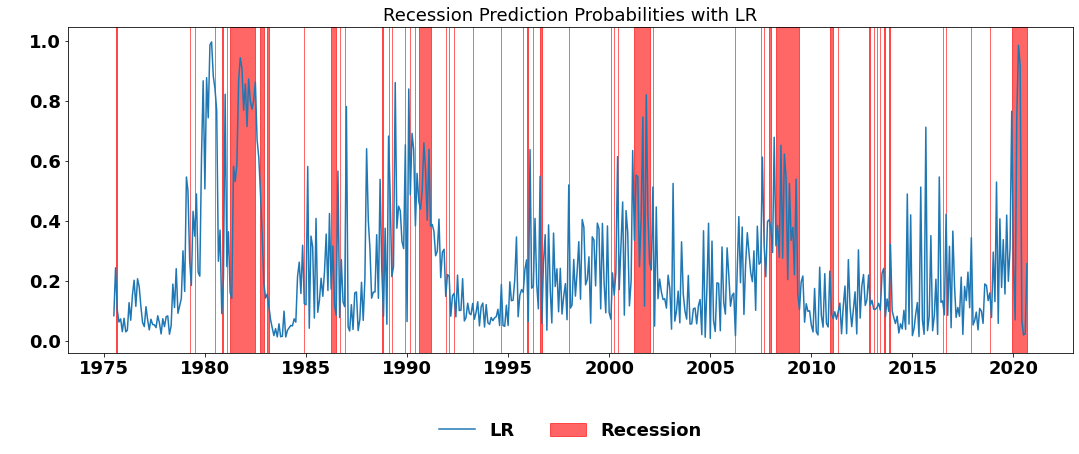

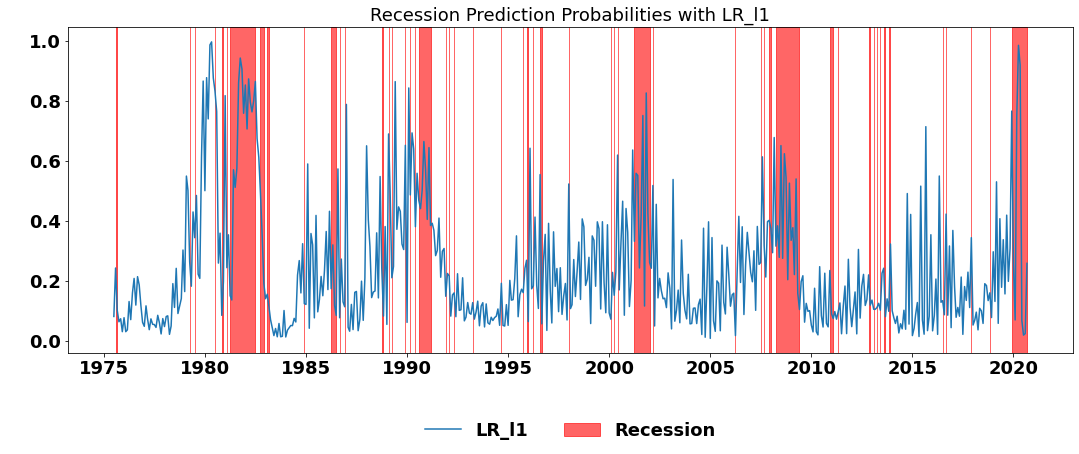

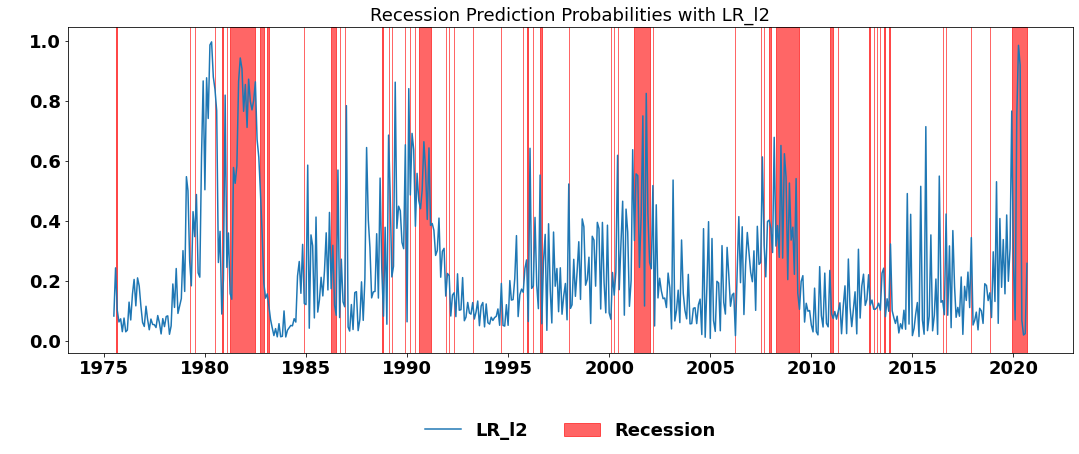

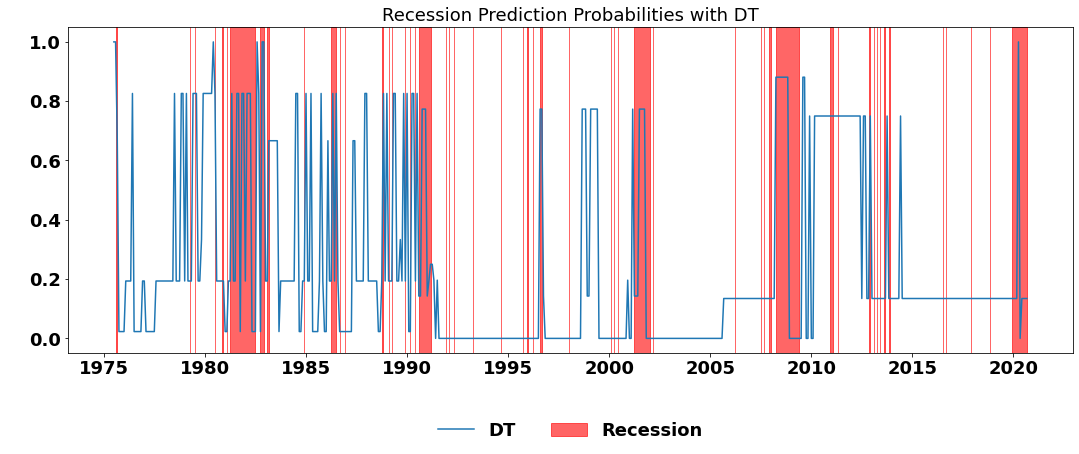

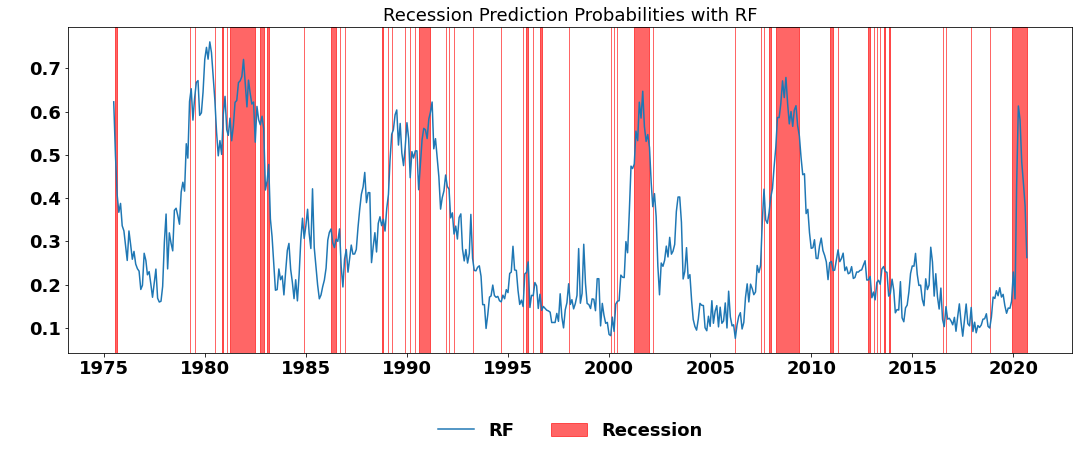

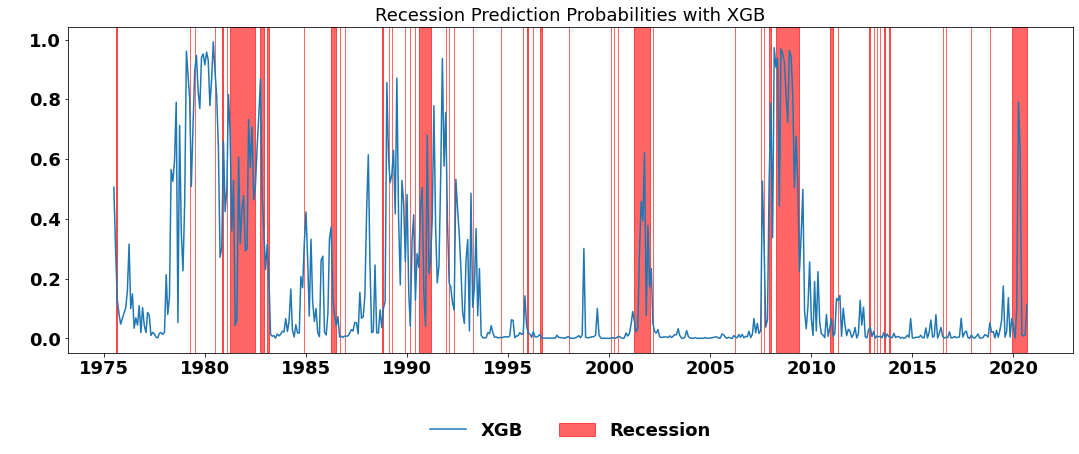

In [18]:
df = res_series_data
for model in list(model_dict.keys()):
  plt_regime(df,plt_series = [model[0]],series_label = [model[0]],regime_label = 'Recession',title = 'Recession Prediction Probabilities with '+model[0])

In [19]:
%%time 
for model_tuple, param in model_dict.items():
    model = model_tuple[1](**param)
    print(model)

LogisticRegression(penalty='none', solver='saga')
LogisticRegression(C=1, penalty='l1', solver='saga')
LogisticRegression(C=0.01, solver='saga')
DecisionTreeClassifier(max_depth=3, splitter='random')
RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)
XGBClassifier(n_estimators=400, random_state=42)
CPU times: user 5.88 ms, sys: 997 µs, total: 6.88 ms
Wall time: 7.05 ms


# Out-of-sample Prediction

Out-of-sample predictions are performed on a rolling window basis. Model performances are evaluated with error metrics and recession prediction probabilities are visualized after that.

In [20]:

df = df_macro.merge(df_regime, on='Date',how='left')
start_date = '1972-09-01'
roll_window = 150
threshold = 0.5 # threshold for binary classification
#####################################################
res_rolling_all= pd.DataFrame([])
t = df[df['Date'] == start_date].index.tolist()[0]
df_pred = df.iloc[t - roll_window:, :]
X = df_pred[feature_col]
y = df_pred[target_col]
date_range = df_pred['Date']
y_prob = np.array([])
date = np.array([], dtype='datetime64[s]')
y_actual = np.array([])
y_binary = np.array([])
for i in np.arange(0, len(df_pred) - roll_window):
    count=0
    for model_tuple, param in model_dict.items():
      count=count+1
      model = model_tuple[1](**param)
      if(count==1):
        break;
    X_fit = X.iloc[i: i + roll_window, :]
    y_fit = y.iloc[i: i + roll_window]
    model = model.fit(X_fit, y_fit)
    X_predict = X.iloc[i + roll_window: i + roll_window + 1, :]
    y_pred = model.predict_proba(X_predict)[:, 1]
    y_prob = np.hstack((y_prob, y_pred))  # append class 1 probabilities
    y_binary = np.hstack((y_binary, 1 if y_pred >= threshold else 0))
    date = np.hstack((date, date_range.iloc[i + roll_window: i + roll_window + 1].values))
    y_actual = np.hstack((y_actual, y.iloc[i + roll_window: i + roll_window + 1].values))

res_model_df = pd.DataFrame.from_dict({'Date': date,
                                        'Regime': y_actual,
                                        'crash_prob': y_prob,
                                        'crash_binary': y_binary})

res_rolling_all = pd.DataFrame.from_dict({'Date': date,
                                              'Regime': y_actual,
                                              'LR_none': y_prob})
err_dict = error_metrics(res_model_df, roc=True)
print("\nscore for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are",err_dict)
print("model currently being built is",model)


score for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are {'ACC': 0.7608318890814558, 'MCC': 0.22846859565769573, 'QPS': 0.17040260279044264, 'AUC': 0.7054919908466819}
model currently being built is LogisticRegression(penalty='none', solver='saga')


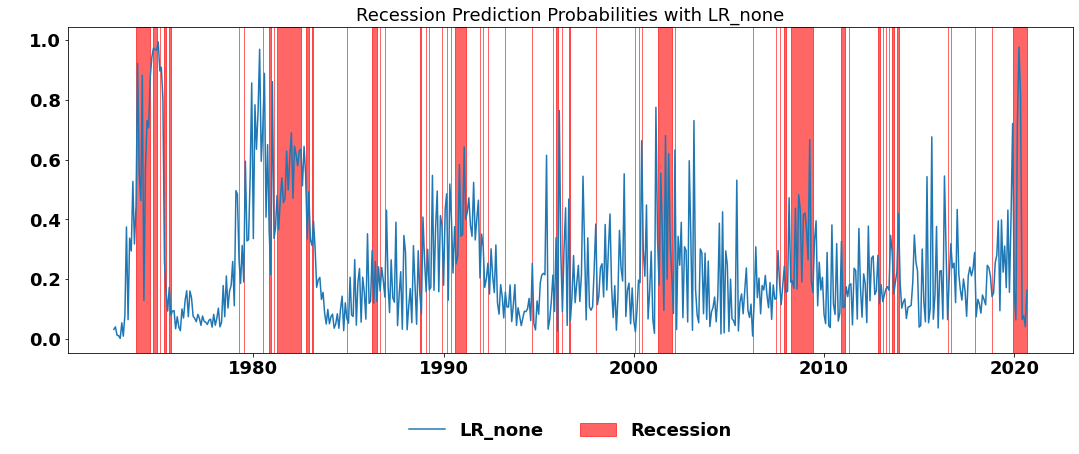

In [21]:
model="LR_none"
df = res_rolling_all
plt_regime(df,plt_series = [model],series_label =[model],regime_label = 'Recession',title = 'Recession Prediction Probabilities with '+model)

In [22]:
df = df_macro.merge(df_regime, on='Date',how='left')
start_date = '1972-09-01'
roll_window = 150
threshold = 0.5 # threshold for binary classification
#####################################################
res_rolling_all= pd.DataFrame([])
t = df[df['Date'] == start_date].index.tolist()[0]
df_pred = df.iloc[t - roll_window:, :]
X = df_pred[feature_col]
y = df_pred[target_col]
date_range = df_pred['Date']
y_prob = np.array([])
date = np.array([], dtype='datetime64[s]')
y_actual = np.array([])
y_binary = np.array([])
for i in np.arange(0, len(df_pred) - roll_window):
  count=0
  for model_tuple, param in model_dict.items():
    count=count+1
    model = model_tuple[1](**param)
    if(count==2):
      break;
    X_fit = X.iloc[i: i + roll_window, :]
    y_fit = y.iloc[i: i + roll_window]
    model = model.fit(X_fit, y_fit)
    X_predict = X.iloc[i + roll_window: i + roll_window + 1, :]
    y_pred = model.predict_proba(X_predict)[:, 1]
    y_prob = np.hstack((y_prob, y_pred))  # append class 1 probabilities
    y_binary = np.hstack((y_binary, 1 if y_pred >= threshold else 0))
    date = np.hstack((date, date_range.iloc[i + roll_window: i + roll_window + 1].values))
    y_actual = np.hstack((y_actual, y.iloc[i + roll_window: i + roll_window + 1].values))

res_model_df = pd.DataFrame.from_dict({'Date': date,
                                        'Regime': y_actual,
                                        'crash_prob': y_prob,
                                        'crash_binary': y_binary})
res_rolling_all = pd.DataFrame.from_dict({'Date': date,
                                              'Regime': y_actual,
                                              'LR_l1': y_prob})
err_dict = error_metrics(res_model_df, roc=True)
print("\nscore for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are",err_dict)
print("model currently being built is",model)


score for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are {'ACC': 0.7608318890814558, 'MCC': 0.22846859565769573, 'QPS': 0.17036567193817995, 'AUC': 0.7055573716900947}
model currently being built is LogisticRegression(C=1, penalty='l1', solver='saga')


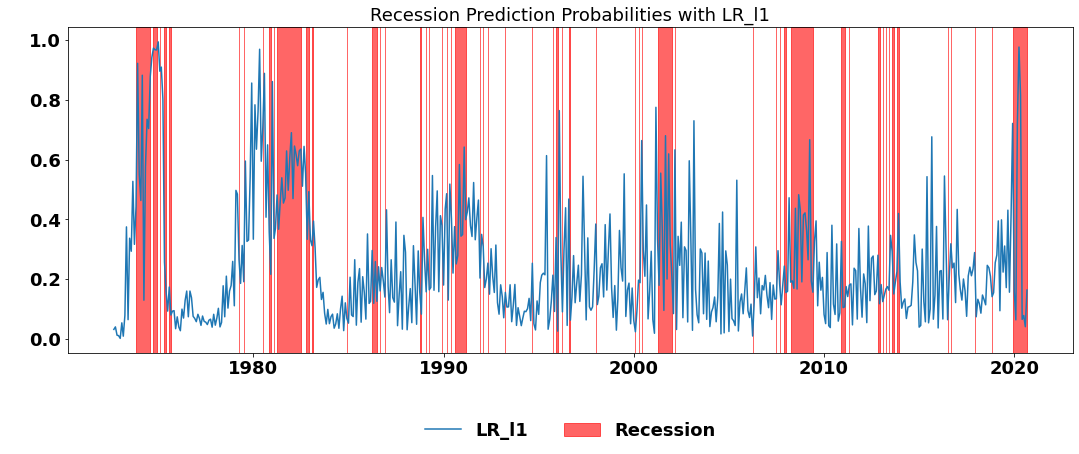

In [23]:

model="LR_l1"
df = res_rolling_all
plt_regime(df,plt_series = [model],series_label =[model],regime_label = 'Recession',title = 'Recession Prediction Probabilities with '+model)

In [24]:
df = df_macro.merge(df_regime, on='Date',how='left')
start_date = '1972-09-01'
roll_window = 150
threshold = 0.5 # threshold for binary classification
#####################################################
res_rolling_all= pd.DataFrame([])
t = df[df['Date'] == start_date].index.tolist()[0]
df_pred = df.iloc[t - roll_window:, :]
X = df_pred[feature_col]
y = df_pred[target_col]
date_range = df_pred['Date']
y_prob = np.array([])
date = np.array([], dtype='datetime64[s]')
y_actual = np.array([])
y_binary = np.array([])
for i in np.arange(0, len(df_pred) - roll_window):
  count=0
  for model_tuple, param in model_dict.items():
    count=count+1
    model = model_tuple[1](**param)
    if(count==3):
      break;
    X_fit = X.iloc[i: i + roll_window, :]
    y_fit = y.iloc[i: i + roll_window]
    model = model.fit(X_fit, y_fit)
    X_predict = X.iloc[i + roll_window: i + roll_window + 1, :]
    y_pred = model.predict_proba(X_predict)[:, 1]
    y_prob = np.hstack((y_prob, y_pred))  # append class 1 probabilities
    y_binary = np.hstack((y_binary, 1 if y_pred >= threshold else 0))
    date = np.hstack((date, date_range.iloc[i + roll_window: i + roll_window + 1].values))
    y_actual = np.hstack((y_actual, y.iloc[i + roll_window: i + roll_window + 1].values))

res_model_df = pd.DataFrame.from_dict({'Date': date,
                                        'Regime': y_actual,
                                        'crash_prob': y_prob,
                                        'crash_binary': y_binary})
res_rolling_all = pd.DataFrame.from_dict({'Date': date,
                                              'Regime': y_actual,
                                              'LR_l2': y_prob})
err_dict = error_metrics(res_model_df, roc=True)
print("\nscore for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are",err_dict)
print("model currently being built is",model)


score for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are {'ACC': 0.7599653379549394, 'MCC': 0.22618352997933744, 'QPS': 0.1706237298245235, 'AUC': 0.7047278522392939}
model currently being built is LogisticRegression(C=0.01, solver='saga')


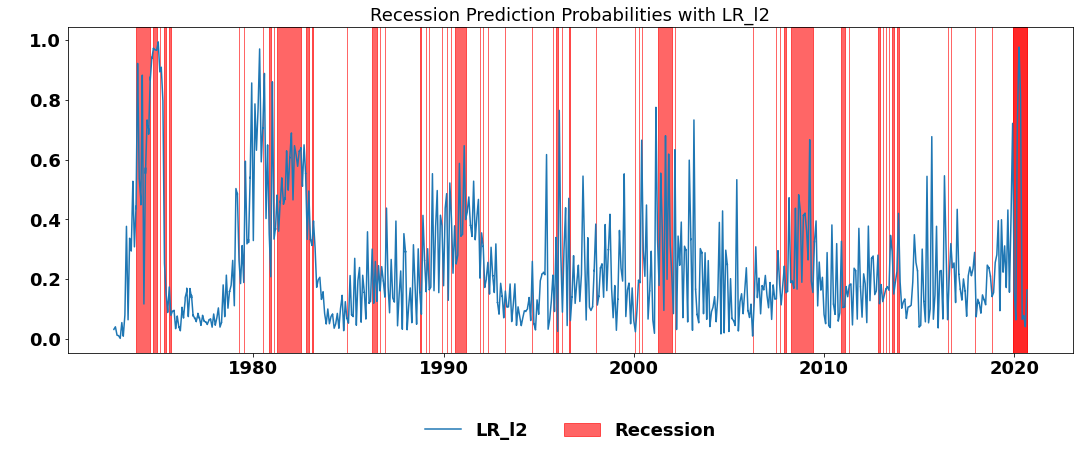

In [25]:

model="LR_l2"
df = res_rolling_all
plt_regime(df,plt_series = [model],series_label =[model],regime_label = 'Recession',title = 'Recession Prediction Probabilities with '+model)

In [26]:
df = df_macro.merge(df_regime, on='Date',how='left')
start_date = '1972-09-01'
roll_window = 150
threshold = 0.5 # threshold for binary classification
#####################################################
res_rolling_all= pd.DataFrame([])
t = df[df['Date'] == start_date].index.tolist()[0]
df_pred = df.iloc[t - roll_window:, :]
X = df_pred[feature_col]
y = df_pred[target_col]
date_range = df_pred['Date']
y_prob = np.array([])
date = np.array([], dtype='datetime64[s]')
y_actual = np.array([])
y_binary = np.array([])
for i in np.arange(0, len(df_pred) - roll_window):
  count=0
  for model_tuple, param in model_dict.items():
    count=count+1
    model = model_tuple[1](**param)
    if(count==4):
      break;
    X_fit = X.iloc[i: i + roll_window, :]
    y_fit = y.iloc[i: i + roll_window]
    model = model.fit(X_fit, y_fit)
    X_predict = X.iloc[i + roll_window: i + roll_window + 1, :]
    y_pred = model.predict_proba(X_predict)[:, 1]
    y_prob = np.hstack((y_prob, y_pred))  # append class 1 probabilities
    y_binary = np.hstack((y_binary, 1 if y_pred >= threshold else 0))
    date = np.hstack((date, date_range.iloc[i + roll_window: i + roll_window + 1].values))
    y_actual = np.hstack((y_actual, y.iloc[i + roll_window: i + roll_window + 1].values))

res_model_df = pd.DataFrame.from_dict({'Date': date,
                                        'Regime': y_actual,
                                        'crash_prob': y_prob,
                                        'crash_binary': y_binary})

res_rolling_all = pd.DataFrame.from_dict({'Date': date,
                                              'Regime': y_actual,
                                              'DT': y_prob})
err_dict = error_metrics(res_model_df, roc=True)
print("\nscore for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are",err_dict)
print("model currently being built is",model)


score for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are {'ACC': 0.7596764875794338, 'MCC': 0.22542607307351184, 'QPS': 0.17059914281317104, 'AUC': 0.7046783625730995}
model currently being built is DecisionTreeClassifier(max_depth=3, splitter='random')


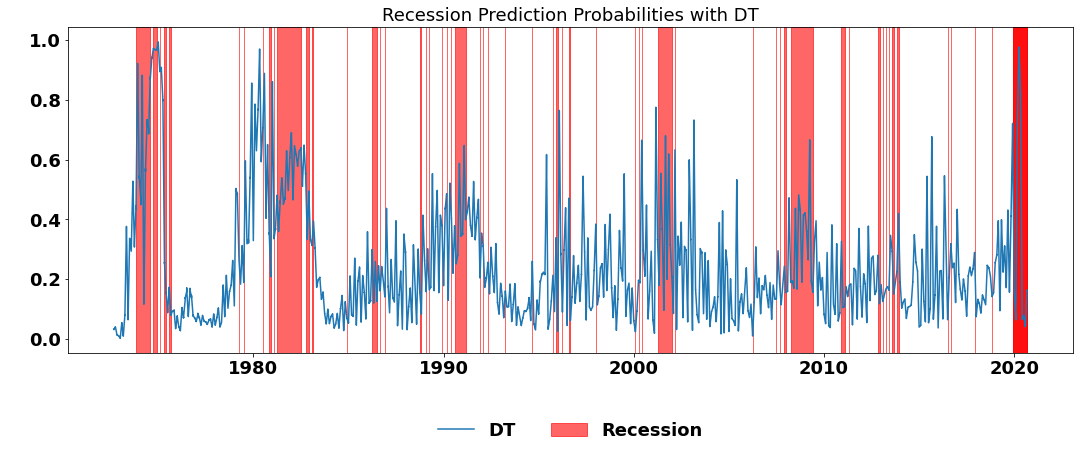

In [27]:
model="DT"
df = res_rolling_all
plt_regime(df,plt_series = [model],series_label =[model],regime_label = 'Recession',title = 'Recession Prediction Probabilities with '+model)

In [28]:
df = df_macro.merge(df_regime, on='Date',how='left')
start_date = '1972-09-01'
roll_window = 150
threshold = 0.5 # threshold for binary classification
#####################################################
res_rolling_all= pd.DataFrame([])
t = df[df['Date'] == start_date].index.tolist()[0]
df_pred = df.iloc[t - roll_window:, :]
X = df_pred[feature_col]
y = df_pred[target_col]
date_range = df_pred['Date']
y_prob = np.array([])
date = np.array([], dtype='datetime64[s]')
y_actual = np.array([])
y_binary = np.array([])
for i in np.arange(0, len(df_pred) - roll_window):
  count=0
  for model_tuple, param in model_dict.items():
    count=count+1
    model = model_tuple[1](**param)
    if(count==5):
      break;
    X_fit = X.iloc[i: i + roll_window, :]
    y_fit = y.iloc[i: i + roll_window]
    model = model.fit(X_fit, y_fit)
    X_predict = X.iloc[i + roll_window: i + roll_window + 1, :]
    y_pred = model.predict_proba(X_predict)[:, 1]
    y_prob = np.hstack((y_prob, y_pred))  # append class 1 probabilities
    y_binary = np.hstack((y_binary, 1 if y_pred >= threshold else 0))
    date = np.hstack((date, date_range.iloc[i + roll_window: i + roll_window + 1].values))
    y_actual = np.hstack((y_actual, y.iloc[i + roll_window: i + roll_window + 1].values))

res_model_df = pd.DataFrame.from_dict({'Date': date,
                                        'Regime': y_actual,
                                        'crash_prob': y_prob,
                                        'crash_binary': y_binary})
res_rolling_all = pd.DataFrame.from_dict({'Date': date,
                                              'Regime': y_actual,
                                              'RF': y_prob})
err_dict = error_metrics(res_model_df, roc=True)
print("\nscore for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are",err_dict)
print("model currently being built is",model)


score for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are {'ACC': 0.7703639514731369, 'MCC': 0.2771438396907315, 'QPS': 0.1707240025736422, 'AUC': 0.709938909774436}
model currently being built is RandomForestClassifier(max_depth=5, n_estimators=200, random_state=42)


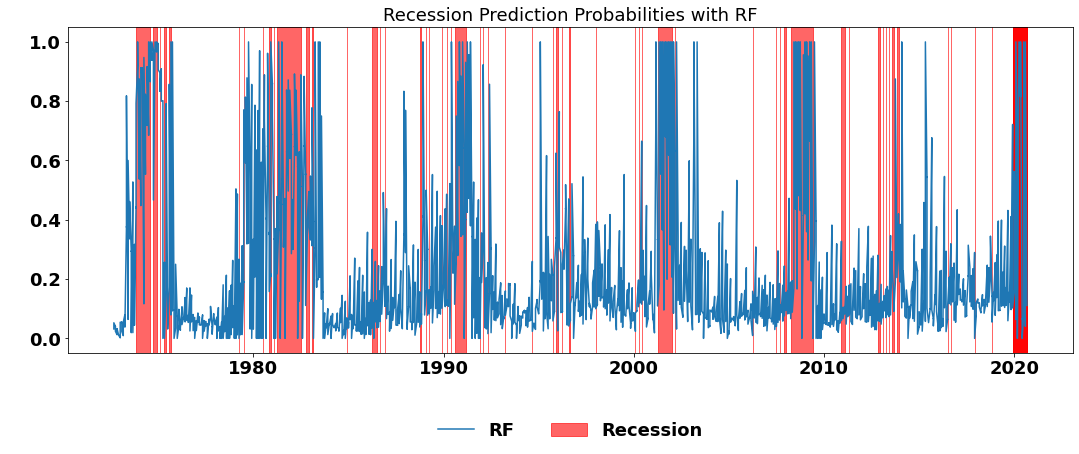

In [29]:
model="RF"
df = res_rolling_all
plt_regime(df,plt_series = [model],series_label =[model],regime_label = 'Recession',title = 'Recession Prediction Probabilities with '+model)

In [30]:
from xgboost import XGBClassifier

In [31]:
df = df_macro.merge(df_regime, on='Date',how='left')
start_date = '1972-09-01'
roll_window = 150
threshold = 0.5 # threshold for binary classification
#####################################################
res_rolling_all= pd.DataFrame([])
t = df[df['Date'] == start_date].index.tolist()[0]
df_pred = df.iloc[t - roll_window:, :]
X = df_pred[feature_col]
y = df_pred[target_col]
date_range = df_pred['Date']
y_prob = np.array([])
date = np.array([], dtype='datetime64[s]')
y_actual = np.array([])
y_binary = np.array([])
for i in np.arange(0, len(df_pred) - roll_window):
  count=0
  for model_tuple, param in model_dict.items():
    count=count+1
    model = model_tuple[1](**param)
    if(count==6):
      break;
    X_fit = X.iloc[i: i + roll_window, :]
    y_fit = y.iloc[i: i + roll_window]
    model = model.fit(X_fit, y_fit)
    X_predict = X.iloc[i + roll_window: i + roll_window + 1, :]
    y_pred = model.predict_proba(X_predict)[:, 1]
    y_prob = np.hstack((y_prob, y_pred))  # append class 1 probabilities
    y_binary = np.hstack((y_binary, 1 if y_pred >= threshold else 0))
    date = np.hstack((date, date_range.iloc[i + roll_window: i + roll_window + 1].values))
    y_actual = np.hstack((y_actual, y.iloc[i + roll_window: i + roll_window + 1].values))

res_model_df = pd.DataFrame.from_dict({'Date': date,
                                        'Regime': y_actual,
                                        'crash_prob': y_prob,
                                        'crash_binary': y_binary})
res_rolling_all = pd.DataFrame.from_dict({'Date': date,
                                              'Regime': y_actual,
                                              'XGB': y_prob})
err_dict = error_metrics(res_model_df, roc=True)
print("\nscore for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are",err_dict)
print("model currently being built is",model)


score for 4 different Evaluation parameters namely ACC,MCC,QPS,AUC are {'ACC': 0.7805892547660311, 'MCC': 0.3200589116260002, 'QPS': 0.1656946737022339, 'AUC': 0.719639424648578}
model currently being built is XGBClassifier(n_estimators=400, random_state=42)


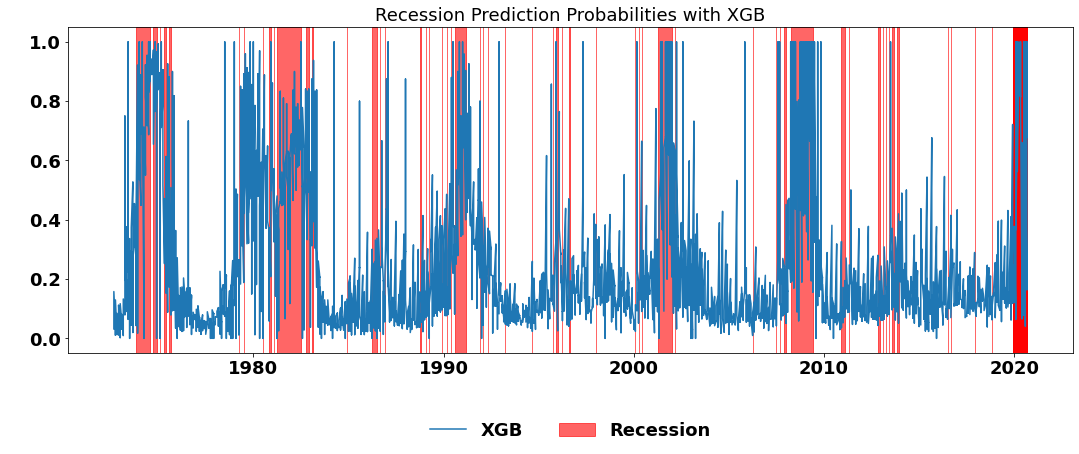

In [32]:

model="XGB"
df = res_rolling_all
plt_regime(df,plt_series = [model],series_label =[model],regime_label = 'Recession',title = 'Recession Prediction Probabilities with '+model)

In [ ]:
!jupyter nbconvert REGIME_PREDICTION_MACHINE_LEARNING_REGIME_INDEX3.ipynb